In [1]:
import numpy as np
from robot_navigation import is_segments_intersect, check_polyline
from matplotlib import pyplot as plt

In [2]:
segment_1 = (np.array([6, 5]), np.array([7, 4])) 
segment_2 = (np.array([3, 7]), np.array([7, 7]))


is_segments_intersect(segment_1, segment_2)

False

In [3]:
obstacles = [
    np.array([[2,2], [2,4], [3,3]]),
	np.array([[5,4], [4,6],[6,5],[7,4]])
]

In [4]:
path = [np.array([0, 0]), 
        np.array([2, 0]), 
        np.array([4, 3]), 
        np.array([3, 5]), 
        np.array([7, 7])]

In [7]:
check_polyline(polyline=path, obstacles=obstacles)

segments intersect: (array([5, 4]), array([4, 6])) (array([3, 5]), array([7, 7]))


False

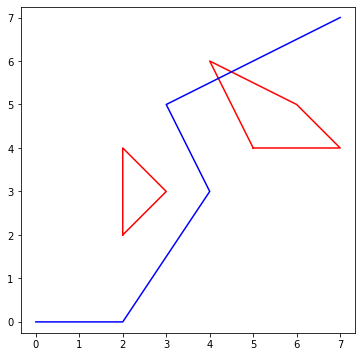

In [8]:
plt.figure(figsize=(6,6))
plt.axis('equal')

for ob in obstacles:
    ob = list(ob)
    ob.append(ob[0])
    x,y = zip(*ob)
    plt.plot(x, y, c='red')
    
x,y = zip(*path)
plt.plot(x,y,'blue')
plt.show()

# solution

In [10]:
import json

with open('robot_data.json', 'r') as f:
    data = json.load(f)
    
data

{'start': [0, 0],
 'finish': [10, 10],
 'obstacles': [[[2, 2], [2, 4], [3, 3]], [[5, 4], [4, 6], [6, 5], [7, 4]]]}

In [104]:
def get_crossed_vec(start, curr_step, obstacles=obstacles):
    crossed_vec = []
    for obs in obstacles:
        for vec1, vec2 in zip(obs, np.vstack([obs[1:], obs[0]])):
            line1 = np.array((vec1, vec2))
            crossed = is_segments_intersect(line1, (start, curr_step))
            if crossed:
                crossed_vec = line1
                break
        if len(crossed_vec)>0:
            break
    return crossed_vec

In [142]:
def get_angle(vec1, vec2):
    norm_v1 = np.linalg.norm(vec1)
    norm_v2 = np.linalg.norm(vec2)
    cosA = np.cross(vec1, vec2)/(norm_v1*norm_v2)
    alpha = np.rad2deg(np.arccos(cosA))
    return alpha

def get_new_direction(crossed_vec, pure_vector):
    a, b = crossed_vec
    angleAB = get_angle(pure_vector, b-a)
    angleBA = get_angle(pure_vector, a-b)
    print(angleAB, angleBA)
    new_dir = b-a if angleAB<angleBA else a-b
    new_dir_normed = new_dir/np.linalg.norm(new_dir)
    return new_dir_normed

In [143]:
start, finish = np.array(data['start']), np.array(data['finish'])
obstacles = data['obstacles']

In [146]:
curr_start = start
my_path = [curr_start]

for _ in range(10):
    pure_vector = finish - curr_start
    pure_vector_normed = pure_vector/np.linalg.norm(pure_vector)

    next_step = curr_start+pure_vector_normed
    crossed_vec = get_crossed_vec(start, next_step)

    if len(crossed_vec):
        new_dir_normed = get_new_direction(crossed_vec, pure_vector)
        curr_start = curr_start+new_dir_normed
    else:
        curr_start = curr_start+pure_vector_normed
    my_path.append(curr_start)

45.0 135.0
39.56723781389748 140.4327621861025
33.12921073153771 146.8707892684623
25.591055086332645 154.40894491366737


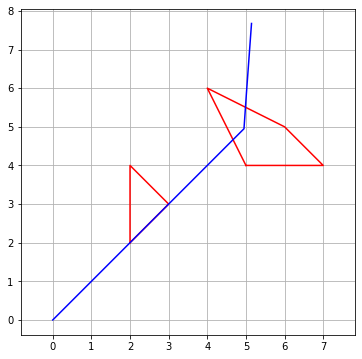

In [147]:
plt.figure(figsize=(6,6))
plt.axis('equal')

for ob in obstacles:
    ob = list(ob)
    ob.append(ob[0])
    x,y = zip(*ob)
    plt.plot(x, y, c='red')
    
x,y = zip(*my_path)
plt.plot(x,y,'blue')
plt.grid()
plt.show()